In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
stack_fixed = 'MD589'
# stack_moving = 'atlas'
stack_moving = 'MD594'

# Global

In [3]:
detector_id = 1
warp_setting = 16

In [4]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                     None
transform_type                     affine
terminate_thresh                    1e-05
grad_computation_sample_number     100000
grid_search_sample_number            1000
std_tx_um                            2000
std_ty_um                            2000
std_tz_um                            2000
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                 NaN
comment                               NaN
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [5]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [6]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_moving[1].shape

File does not exist: /shared/CSHL_volumes/MD594/MD594_down32_annotationVolume/MD594_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp"
(347, 538, 373)


File does not exist: /shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_prep2_detector1_down32_scoreVolume/score_volumes/MD594_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (347, 538, 373)


In [7]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

File does not exist: /shared/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp"
(373, 485, 381)


File does not exist: /shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/MD589/MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD589_prep2_detector1_down32_scoreVolume_sp5.bp'
Volume shape: (373, 485, 381)


In [8]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R', 
#                     'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
#                     'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']
structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
                    'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
                    'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R',
                   'Sp5C_L', 'Sp5C_R']

In [9]:
structure_subset = set([convert_to_original_name(name_s) for name_s in structure_subset])

In [10]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# Compute registration

In [35]:
nzvoxels_m = {label: parallel_where_binary(vol > 0.8) for label, vol in volume_moving.iteritems()}

In [36]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f,
                  nzvoxels_m_=nzvoxels_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [37]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

m: [ 269.   173.5  186.5] f: [ 242.5  186.5  190.5]


In [38]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                        grid_search_sample_number=5,
#                       std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                        grid_search_eta=3.)

In [39]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                          detector_id=detector_id, 
                                                         prep_id=2)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [40]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f)

set([2, 5, 7, 8, 16, 21, 22, 25, 26, 27, 28])


load gradient 2: 4.704736 seconds
load gradient 5: 4.339346 seconds
load gradient 7: 4.652784 seconds
load gradient 8: 6.195268 seconds
load gradient 16: 3.578496 seconds
load gradient 21: 3.827162 seconds
load gradient 22: 2.900202 seconds
load gradient 25: 5.195727 seconds
load gradient 26: 4.503525 seconds
load gradient 27: 3.399741 seconds
load gradient 28: 3.351811 seconds
overall: 46.650037 seconds


In [ ]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 5

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh=terminate_thresh,
                                     grad_computation_sample_number=10000,
                                     lr1=lr1, lr2=lr2)
#                                     init_T=grid_search_T)
        traj = aligner.Ts    
    
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(traj)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
2: 10000 samples out of 165076
5: 10000 samples out of 251620
7: 10000 samples out of 247410
8: 10000 samples out of 473293
16: 10000 samples out of 176105
21: 10000 samples out of 319712
22: 10000 samples out of 148922
25: 10000 samples out of 58269
26: 10000 samples out of 44132
27: 10000 samples out of 381864
28: 10000 samples out of 373950
in T: 0.00 0.00 0.00, out T: 9.85 9.91 9.88
step: 0.81 seconds
current score: 0.409270
new_T: [ 9.84835976  9.90697119  9.87859559]
det: 1.10

iteration 1
2: 10000 samples out of 164886
5: 10000 samples out of 246550
7: 10000 samples out of 246904
8: 10000 samples out of 472863
16: 10000 samples out of 156691
21: 10000 samples out of 323584
22: 10000 samples out of 153940
25: 10000 samples out of 55228
26: 10000 samples out of 34043
27: 10000 samples out of 392122
28: 10000 samples out of 359931
in T: 9.85 9.91 9.88, out T: 6.33 10.33 2.05
step: 0.84 seconds
current score: 0.357128
new_T: [  6.32673435  10.33285749   2.04627726]
det:

8: 10000 samples out of 501171
16: 10000 samples out of 177337
21: 10000 samples out of 331771
22: 10000 samples out of 160590
25: 10000 samples out of 58511
26: 10000 samples out of 44998
27: 10000 samples out of 388827
28: 10000 samples out of 390326
in T: 17.49 18.20 -5.32, out T: 18.80 16.86 -3.64
step: 0.85 seconds
current score: 0.752431
new_T: [ 18.80375402  16.86429774  -3.63626819]
det: 0.95

iteration 17
2: 10000 samples out of 164181
5: 10000 samples out of 248763
7: 10000 samples out of 245513
8: 10000 samples out of 499924
16: 10000 samples out of 176234
21: 10000 samples out of 333100
22: 10000 samples out of 161758
25: 10000 samples out of 58591
26: 10000 samples out of 45425
27: 10000 samples out of 391393
28: 10000 samples out of 394617
in T: 18.80 16.86 -3.64, out T: 17.42 19.39 -5.73
step: 0.86 seconds
current score: 0.769194
new_T: [ 17.41770594  19.3896928   -5.73326619]
det: 0.99

iteration 18
2: 10000 samples out of 164092
5: 10000 samples out of 248572
7: 10000 

22: 10000 samples out of 161714
25: 10000 samples out of 58472
26: 10000 samples out of 45190
27: 10000 samples out of 390606
28: 10000 samples out of 392586
in T: 19.22 18.89 -6.35, out T: 21.14 17.13 -4.64
step: 0.85 seconds
current score: 0.760287
new_T: [ 21.13706345  17.12593625  -4.63982585]
det: 0.96

iteration 33
2: 10000 samples out of 164262
5: 10000 samples out of 248894
7: 10000 samples out of 245671
8: 10000 samples out of 500617
16: 10000 samples out of 176340
21: 10000 samples out of 333449
22: 10000 samples out of 161536
25: 10000 samples out of 58563
26: 10000 samples out of 45250
27: 10000 samples out of 390991
28: 10000 samples out of 392727
in T: 21.14 17.13 -4.64, out T: 19.46 18.82 -5.90
step: 0.86 seconds
current score: 0.786712
new_T: [ 19.4591725   18.82047258  -5.89719   ]
det: 0.97

iteration 34
2: 10000 samples out of 164058
5: 10000 samples out of 248379
7: 10000 samples out of 245260
8: 10000 samples out of 501061
16: 10000 samples out of 177022
21: 10000 

[[  0.92761892  -0.26665      0.04667153  20.59176825]
 [  0.20935312   0.95594164  -0.06355155  17.7709757 ]
 [ -0.05525399   0.09464708   1.01646108  -5.20470477]]
0.794232236221 0.79143178463


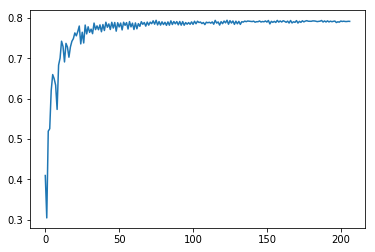

In [42]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [45]:
params_fp = \
DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

##################################

history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores), history_fp)
upload_to_s3(history_fp)

##################################

score_plot_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)

upload_to_s3(score_plot_fp)

##################################

trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              detector_id_f=detector_id,
                                              prep_id_f=2,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_sco

# Local

In [5]:
detector_id = 1
warp_setting = 17

In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                       16
transform_type                      rigid
terminate_thresh                    1e-06
grad_computation_sample_number     100000
grid_search_sample_number           10000
std_tx_um                             200
std_ty_um                             200
std_tz_um                             200
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                   0
comment                               NaN
Name: 17, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [59]:
structure = '7N'

In [60]:
volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, 
                                                                             stack_f=stack_fixed,
                                                                             prep_id_f=2, 
                                                                 detector_id_f=detector_id,
                                                                 warp_setting=upstream_warp_setting, 
                                                                 structures=[structure])

Prior structure/index map not found. Generating a new one.


In [61]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, prep_id=2, detector_id=detector_id, 
                                                      sided=False, volume_type='score',structures=[structure])

Prior structure/index map not found. Generating a new one.
Volume shape: (373, 485, 381)


In [62]:
# gradient_filepath_map_f = {ind_f: \
#                            DataManager.get_volume_gradient_filepath_template(\
#                             stack=stack_fixed, structure=struct_f, prep_id=2, detector_id=detector_id)
#                            for ind_f, struct_f in label_to_structure_fixed.iteritems()}

In [63]:
if include_surround:
    volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, 
                                 stack_f=stack_fixed, prep_id_f=2, detector_id_f=detector_id, warp_setting=upstream_warp_setting, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, 
                                                                             stack_f=stack_fixed,
                                                                             prep_id_f=2, 
                                                                 detector_id_f=detector_id,
                                                                 warp_setting=upstream_warp_setting, 
                                                                 structures=[structure])
    
margin = 30
struct_xmin, struct_xmax, struct_ymin, struct_ymax, struct_zmin, struct_zmax = (219, 278, 291, 340, 246, 300)

out_bbox = (struct_xmin-margin,struct_xmax+margin,
struct_ymin-margin,struct_ymax+margin,
struct_zmin-margin,struct_zmax+margin)

volume_moving_local = {k: crop_and_pad_volume(v, out_bbox=out_bbox) for k, v in volume_moving.iteritems()}
    
    
structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving_local.keys()))}
label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving_local.keys()))}
volume_moving_local = {structure_to_label_moving[s]: v for s, v in volume_moving_local.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

if surround_weight == 'inverse':
#             if 'volume_moving_structure_sizes' not in locals():
    volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving_local.iteritems()}
    label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                       /float(volume_moving_structure_sizes[label_m])
                       if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
    label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
else:
    sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)


volume_fixed_local = {k: crop_and_pad_volume(v, out_bbox=out_bbox) for k, v in volume_fixed.iteritems()}
    
aligner = Aligner4(volume_fixed_local, volume_moving_local, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_7N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_7N_surround_200.bp" "/shared/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_7N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_7N_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/MD594/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume/score_volumes/MD594_down32_scoreVolume_warp16_MD589_prep2_detector1_down32_scoreVolume_7N_surround_200.bp'
Score volume for 7N_surround_200 does not exist.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 60.   55.   57.5], centroid_f: [ 60.   55.   57.5]


In [64]:
gradient_f_local = {}
for k, v in volume_fixed_local.iteritems():
    gy, gx, gz = np.gradient(v)
    gradient_f_local[k] = np.array([gx,gy,gz])

In [65]:
aligner.load_gradient(gradients=gradient_f_local)

indices_f: set([1])


In [66]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [67]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

In [73]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=1000, 
                                 history_len=50, 
                                 terminate_thresh=1e-5,
                                 grad_computation_sample_number=100000,
                                 lr1=1, lr2=1e-1)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))



iteration 0
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.02 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.02 s
fancy indexing into fixed volume gradient: 0.04 s
1: 100000 samples out of 868315
sample: 0.20 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.125121
new_T: [ 0.01522328 -0.04807034  0.06709506]
det: 1.00

iteration 1
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.02 s
fancy indexing into fixed volume gradient: 0.04 s
1: 100000 samples out of 816095
sample: 0.20 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 secon

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.097276
new_T: [-0.05302731 -0.45327588  0.58761059]
det: 1.00

iteration 16
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 702497
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.097071
new_T: [-0.06819221 -0.48472246  0.61387178]
det: 1.00

iteration 17
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 

sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.096963
new_T: [-0.33416426 -0.78503294  0.86928108]
det: 1.00

iteration 32
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 741821
sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.097174
new_T: [-0.358334   -0.79035501  0.88741675]
det: 1.00

iteration 33
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 

sample: 0.20 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.35 seconds
current score: 0.097902
new_T: [-0.62809281 -1.06020896  1.1194052 ]
det: 1.00

iteration 48
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.02 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 788625
sample: 0.20 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.35 seconds
current score: 0.097624
new_T: [-0.65572916 -1.07268276  1.13041897]
det: 1.00

iteration 49
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.02 

sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.092589
new_T: [-0.94232363 -1.27968461  1.30500398]
det: 1.00

iteration 64
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 751184
sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.092314
new_T: [-0.96514493 -1.2878955   1.30993829]
det: 1.00

iteration 65
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 

sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.089303
new_T: [-1.22487135 -1.46617166  1.41416139]
det: 1.00

iteration 80
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 730189
sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.089260
new_T: [-1.24390458 -1.47790959  1.41842775]
det: 1.00

iteration 81
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 

sample: 0.19 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.087889
new_T: [-1.46302243 -1.65289611  1.43223966]
det: 1.00

iteration 96
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 718440
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.087792
new_T: [-1.47589942 -1.66531788  1.4352219 ]
det: 1.00

iteration 97
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.33 seconds
current score: 0.087209
new_T: [-1.65614674 -1.80920477  1.43501878]
det: 1.00

iteration 112
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 710998
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.087169
new_T: [-1.66525651 -1.81529254  1.43839188]
det: 1.00

iteration 113
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086920
new_T: [-1.81720339 -1.95675902  1.41999691]
det: 1.00

iteration 128
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 706336
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086874
new_T: [-1.8265861  -1.96326293  1.41668981]
det: 1.00

iteration 129
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086838
new_T: [-1.97732667 -2.09087259  1.40057019]
det: 1.00

iteration 144
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 704272
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086846
new_T: [-1.98608706 -2.09863454  1.39502972]
det: 1.00

iteration 145
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086867
new_T: [-2.10886346 -2.2060618   1.36194131]
det: 1.00

iteration 160
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 703866
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.086906
new_T: [-2.11687608 -2.21407614  1.35715297]
det: 1.00

iteration 161
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.087303
new_T: [-2.23224852 -2.30617111  1.28986539]
det: 1.00

iteration 176
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 704123
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.087312
new_T: [-2.2407654  -2.30883022  1.2891568 ]
det: 1.00

iteration 177
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.087892
new_T: [-2.35326303 -2.42164979  1.24891944]
det: 1.00

iteration 192
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.01 s
fancy indexing into fixed volume gradient: 0.06 s
1: 100000 samples out of 704779
sample: 0.18 s
compute gradient, all voxels: 0.00 s
compute gradient, sum: 0.00 s
step: 0.32 seconds
current score: 0.087953
new_T: [-2.36133261 -2.42903682  1.24789245]
det: 1.00

iteration 193
get_valid_voxels_after_transform: 0.02 seconds.
fancy indexing valid voxels into fixed volume: 0.02 seconds.
fancy indexing into moving volume nz voxels: 0.01 s
fancy indexing into moving volume: 0.01 s
fancy indexing into centralized moving volume nzvoxels: 0.0

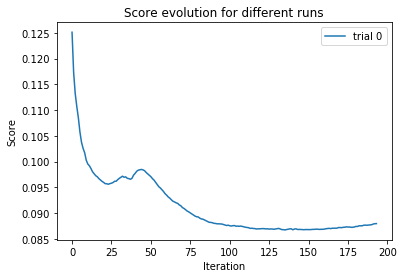

In [74]:
plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different runs');

In [70]:
print T.reshape((3,4))

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]


In [71]:
T, aligner.centroid_m, aligner.centroid_f

(array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]),
 array([ 60. ,  55. ,  57.5]),
 array([ 60. ,  55. ,  57.5]))

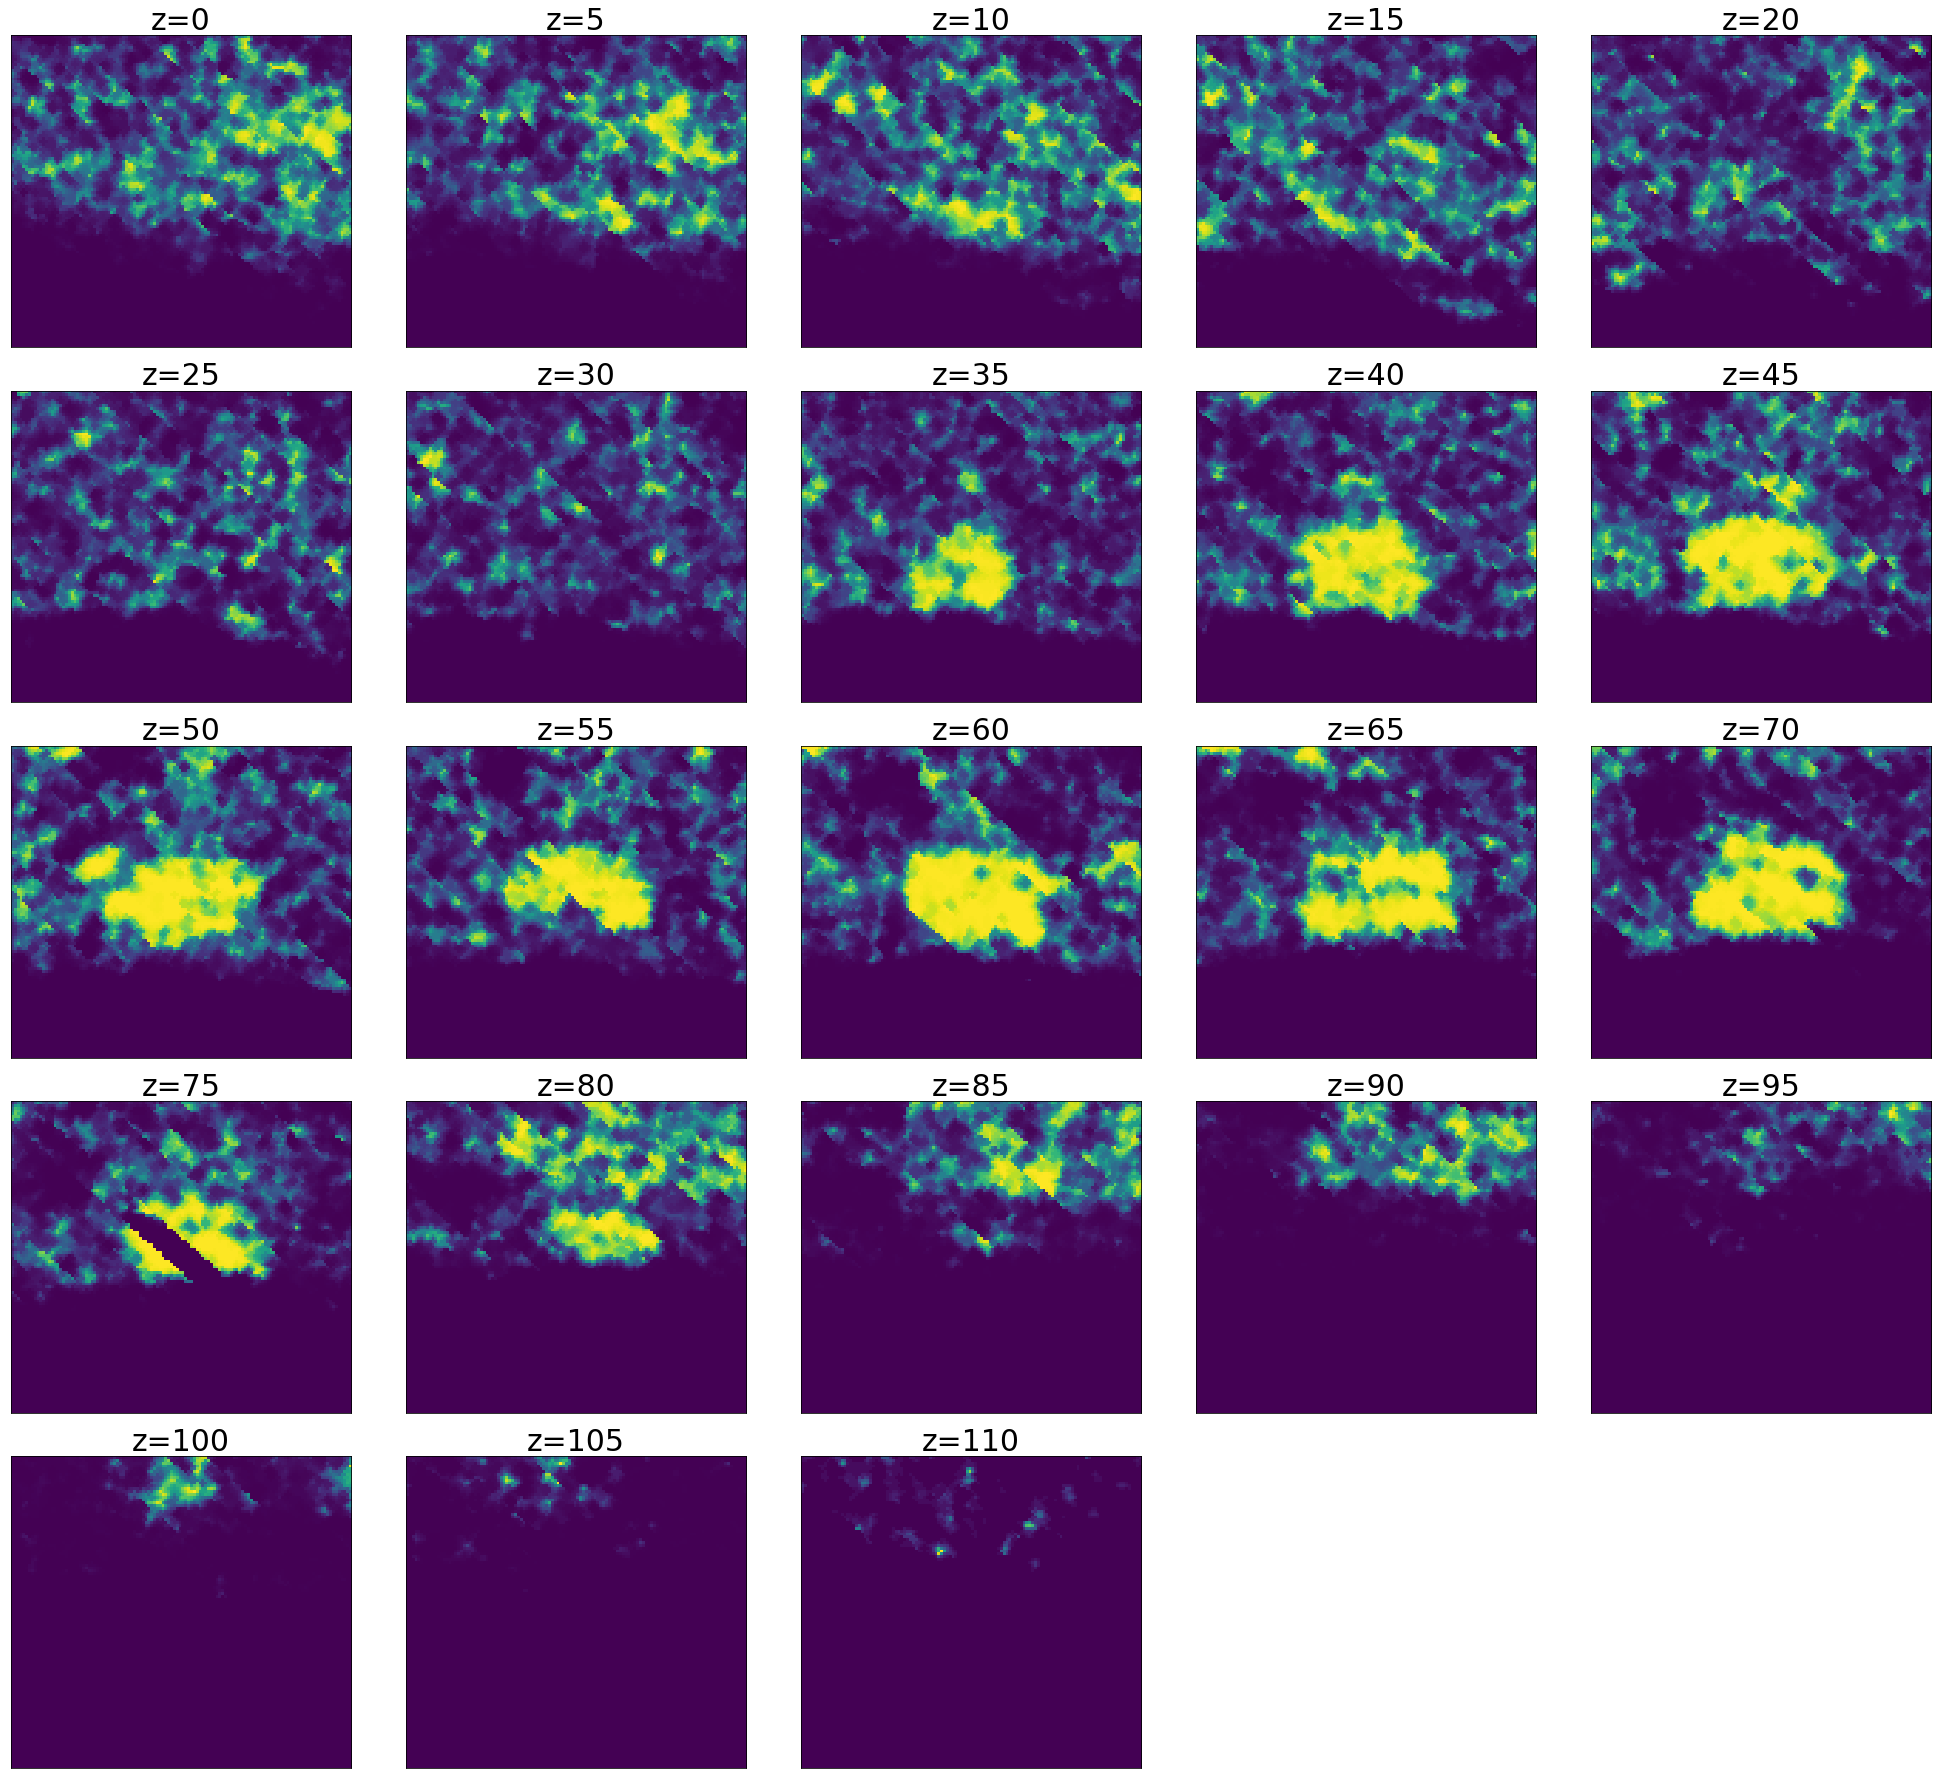

In [31]:
display_volume_sections(volume_moving_local[1], start_level=0)

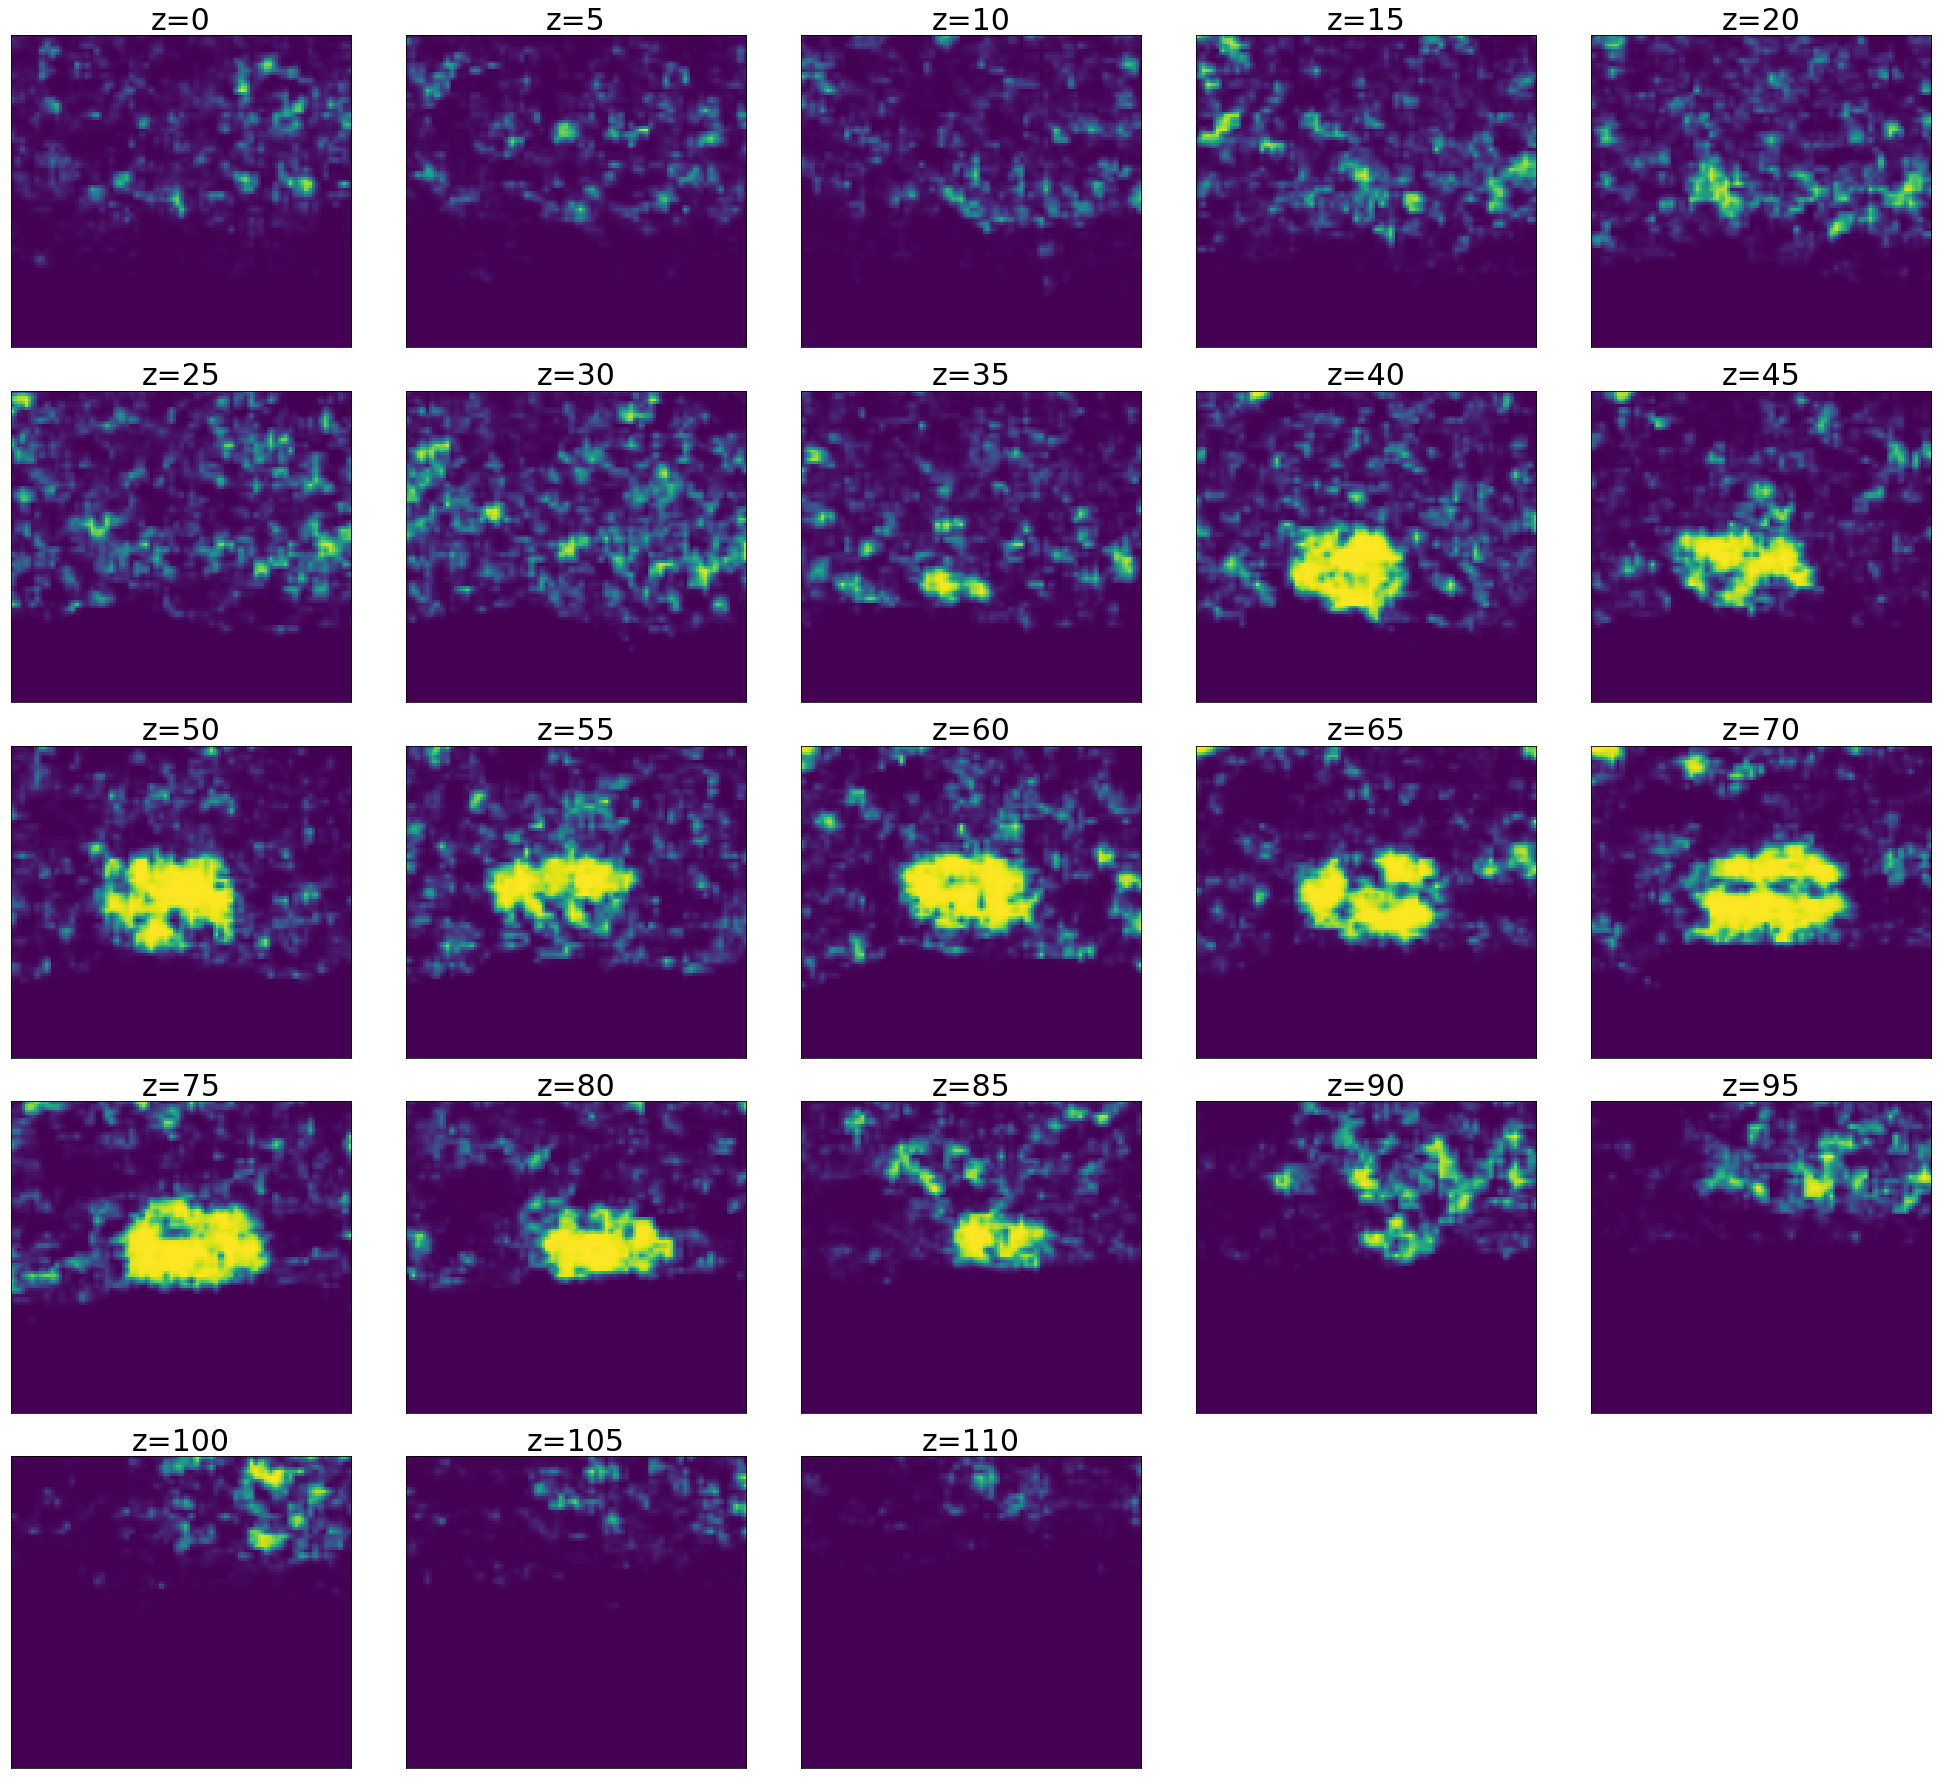

In [30]:
display_volume_sections(volume_fixed_local[1], start_level=0, vmin=0, vmax=1)